2025-06-11 10:32:24,004 | INFO    | ==========  STAGE 07: RISE-PROBABILITY EXPLORATION ==========
2025-06-11 10:32:24,005 | INFO    | RUN_DIR=C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250610  SWAN_YEAR=2008  RUN_DATE=20250610
2025-06-11 10:32:24,106 | INFO    | Loaded Stage6_RISE_Predictions.csv (974 rows)

=== Domain-weighted mean probabilities ===
                     Metric  Mean_Resilience_Prob
          OperatingCashFlow              0.893688
                GrossProfit              0.828350
               TotalRevenue              0.797342
                     EBITDA              0.759690
            OperatingIncome              0.751938
EarningBeforeInterestAndTax              0.735327
                       Cash              0.712071
                  NetIncome              0.705426
     CashAndCashEquivalents              0.684385
               FreeCashFlow              0.677741


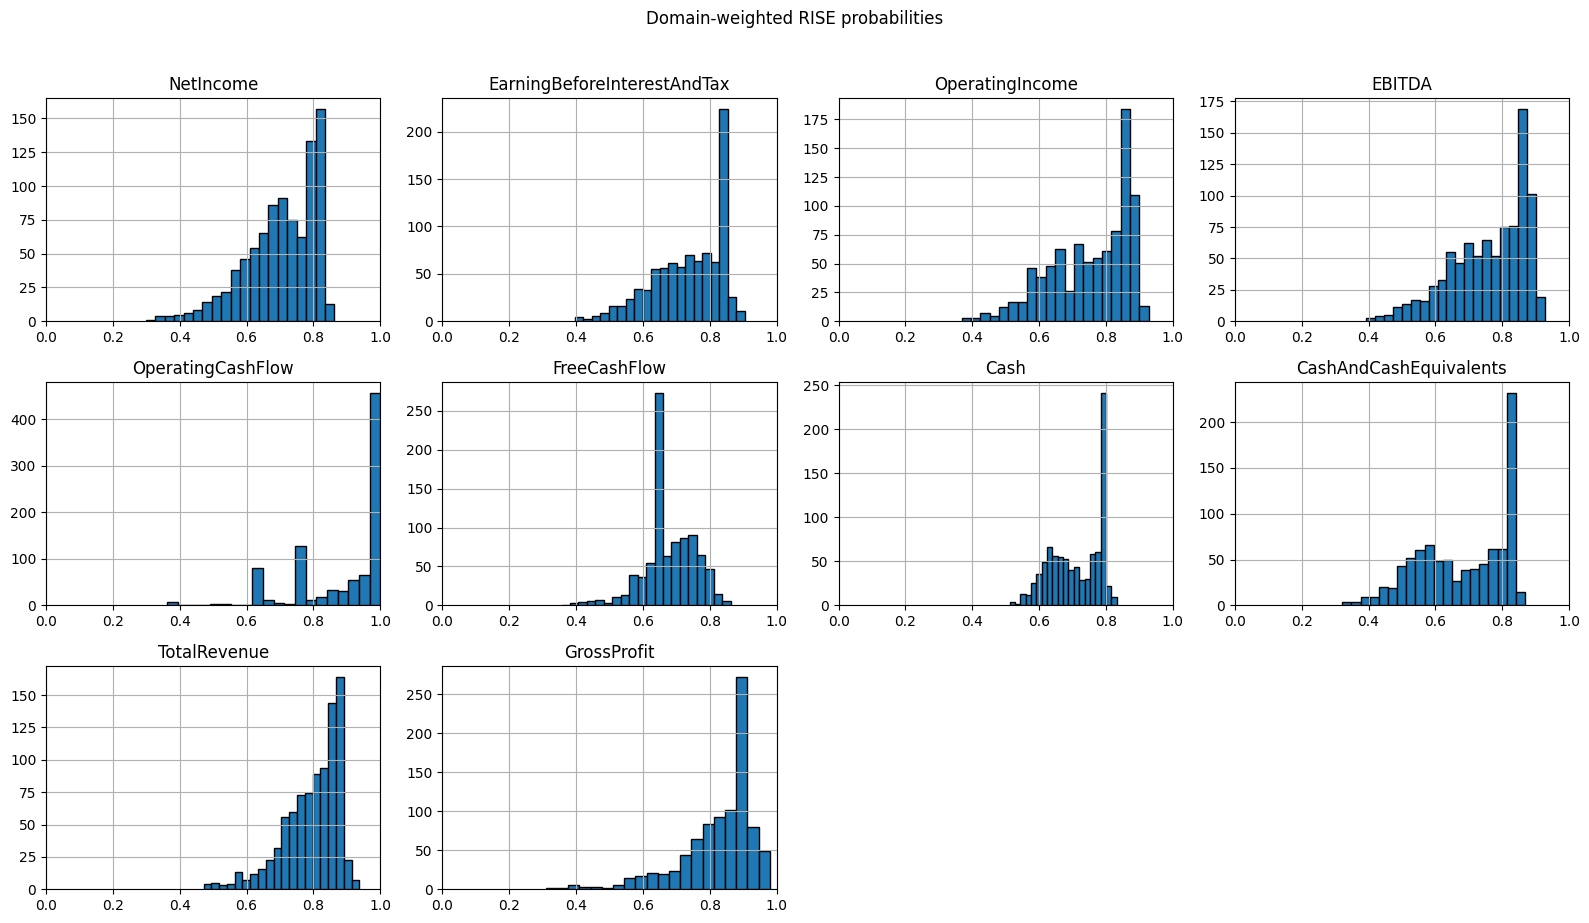

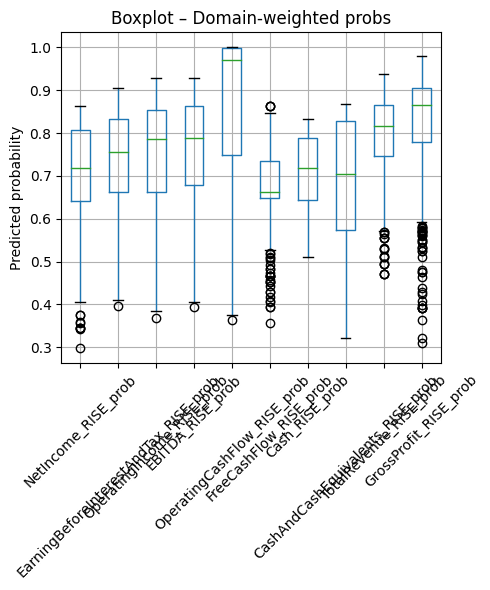

2025-06-11 10:32:25,555 | WARNING | Stage6B_Stage_RISE_Predictions.csv missing – skipped Stage-weighted exploration
2025-06-11 10:32:25,561 | INFO    | ✅ Stage 07 complete – artefacts in C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250610\stage07

✅ Stage 07 complete – outputs in C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250610\stage07



In [10]:
#!/usr/bin/env python
"""
STAGE 07 · RISE-PROBABILITY EXPLORATION & DUAL LEADERBOARD COMPARISON
"""

from __future__ import annotations
# ── stdlib / 3rd-party ──────────────────────────────────────────────
from pathlib import Path
from typing import Dict
import os, sys, logging, warnings, math

import pandas as pd
import matplotlib.pyplot as plt

# ── shared helpers (added in earlier stages) ────────────────────────
from pipeline_utils import load_cfg, resolve_run_dir

# ╔══════════════════════════════════════════════════════════════════╗
# 0 · BOOTSTRAP (config · run-folder · logger)
# ╚══════════════════════════════════════════════════════════════════╝
CFG: Dict      = load_cfg()
EVENTS: Dict   = {str(k): v for k, v in CFG.get("events", {}).items()}

SWAN_YEAR: str = os.getenv("SWAN_YEAR") or next(iter(EVENTS))
if SWAN_YEAR not in EVENTS:
    raise KeyError(f"SWAN_YEAR={SWAN_YEAR} not present in YAML events")

# ── NOTE: now require the *file* written by Stage-06, not just the folder
RUN_DIR  = resolve_run_dir(
    must_have="stage06/Stage6_RISE_Predictions.csv")        # ← FIXED
RUN_DATE = RUN_DIR.name

STAGE07_DIR = RUN_DIR / "stage07"
STAGE07_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)-7s | %(message)s",
    handlers=[
        logging.FileHandler(STAGE07_DIR / "stage07.log", mode="w", encoding="utf-8"),
        logging.StreamHandler(sys.stdout),
    ],
)
logger = logging.getLogger(__name__)
logger.info("==========  STAGE 07: RISE-PROBABILITY EXPLORATION ==========")
logger.info("RUN_DIR=%s  SWAN_YEAR=%s  RUN_DATE=%s", RUN_DIR, SWAN_YEAR, RUN_DATE)
warnings.filterwarnings("ignore", category=RuntimeWarning)

DATE_COL = globals().get("DATE_COL", "ReportDate")
ID_COL   = globals().get("ID_COL",   "Symbol")

# ═══════════════════════════════════════════════════════════════════
# 1 · EXPLORATION HELPER
# ═══════════════════════════════════════════════════════════════════
def explore_predictions(csv_file: Path, weight_tag: str) -> pd.DataFrame:
    if not csv_file.is_file():
        logger.warning("%s missing – skipped %s-weighted exploration",
                       csv_file.name, weight_tag)
        return pd.DataFrame()

    df = pd.read_csv(csv_file)
    logger.info("Loaded %s (%d rows)", csv_file.name, len(df))

    suffix    = "_StageRISE_prob" if weight_tag == "Stage" else "_RISE_prob"
    prob_cols = [c for c in df.columns if c.endswith(suffix)]
    if not prob_cols:
        logger.warning("No '%s' columns – skipped", suffix)
        return pd.DataFrame()

    # ---- ranking ----------------------------------------------------
    rank_df = (df[prob_cols].mean()
                 .sort_values(ascending=False)
                 .rename("Mean_Resilience_Prob")
                 .reset_index()
                 .rename(columns={"index": "Metric"}))
    rank_df["Metric"] = rank_df["Metric"].str.replace(suffix, "", regex=False)
    print(f"\n=== {weight_tag}-weighted mean probabilities ===")
    print(rank_df.to_string(index=False))

    # ---- histogram grid --------------------------------------------
    n = len(prob_cols); n_cols = 4; n_rows = math.ceil(n / n_cols) or 1
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 3*n_rows), squeeze=False)
    axes = axes.flatten()
    for ax, col in zip(axes, prob_cols):
        df[col].dropna().hist(bins=20, ax=ax, edgecolor="k")
        ax.set_title(col.replace(suffix, "")); ax.set_xlim(0,1)
    for ax in axes[n:]:
        ax.axis("off")
    plt.suptitle(f"{weight_tag}-weighted RISE probabilities", y=1.02)
    plt.tight_layout(); plt.show()

    # ---- boxplot ----------------------------------------------------
    plt.figure(figsize=(min(12, 1+0.4*n), 6))
    df[prob_cols].boxplot(rot=45)
    plt.title(f"Boxplot – {weight_tag}-weighted probs")
    plt.ylabel("Predicted probability"); plt.tight_layout(); plt.show()

    return rank_df

# ═══════════════════════════════════════════════════════════════════
# 2 · RUN EXPLORATION
# ═══════════════════════════════════════════════════════════════════
rank_domain = explore_predictions(RUN_DIR / "stage06" / "Stage6_RISE_Predictions.csv",
                                  "Domain")
rank_stage  = explore_predictions(RUN_DIR / "stage06" / "Stage6B_Stage_RISE_Predictions.csv",
                                  "Stage")

# ═══════════════════════════════════════════════════════════════════
# 3 · SAVE LEADERBOARDS & COMPARISON
# ═══════════════════════════════════════════════════════════════════
if not rank_domain.empty:
    rank_domain.to_csv(STAGE07_DIR / "Stage7C_Rank_Domain.csv", index=False)
if not rank_stage.empty:
    rank_stage.to_csv(STAGE07_DIR / "Stage7C_Rank_Stage.csv",  index=False)

if not rank_domain.empty and not rank_stage.empty:
    comp = (rank_domain
              .merge(rank_stage, on="Metric",
                     suffixes=("_Domain", "_Stage"))
              .assign(Diff=lambda d:
                      d["Mean_Resilience_Prob_Domain"]
                    - d["Mean_Resilience_Prob_Stage"])
              .sort_values("Mean_Resilience_Prob_Domain", ascending=False))
    comp.to_csv(STAGE07_DIR / "Stage7C_Domain_vs_Stage_Comparison.csv",
                index=False)

    print("\n=== Domain – Stage probability gap ===")
    print(comp.to_string(index=False))

    comp.plot(x="Metric", y="Diff", kind="bar",
              title="Domain minus Stage (mean probability)",
              ylabel="Gap", figsize=(10,4), rot=45, legend=False)
    plt.axhline(0, color="k"); plt.tight_layout(); plt.show()

logger.info("✅ Stage 07 complete – artefacts in %s", STAGE07_DIR)
print(f"\n✅ Stage 07 complete – outputs in {STAGE07_DIR}\n")